In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# CIFAR 데이터셋 다운 및 로드

transform = transforms.Compose(
    [transforms.ToTensor()])


batch_size = 4

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

cifar_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


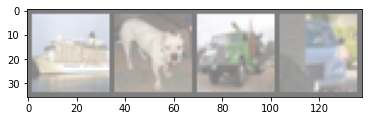

ship  dog   truck car  
(3, 32, 32)


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{cifar_classes[labels[j]]:5s}' for j in range(batch_size)))
print(images[0].numpy().shape)

In [4]:
import torch.nn as nn

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, downsample=None, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=inchannel, out_channels=outchannel, kernel_size=3, padding=1, stride=stride)
        self.bn1 =  nn.BatchNorm2d(outchannel)

        self.conv2 = nn.Conv2d(in_channels=outchannel, out_channels=outchannel, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(outchannel)

        self.relu = nn.ReLU(inplace=True) #activation function
        self.stride = stride
        self.downsample = downsample
        self.out_channels = outchannel
        
    
    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out+identity)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1_0 = ResidualBlock(inchannel=64, outchannel=64, stride=1)
        self.layer1_1 = ResidualBlock(inchannel=64, outchannel=64, stride=1)
        downsample_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(128),
        )
        self.layer2_0 = ResidualBlock(inchannel=64, outchannel=128, downsample=downsample_2, stride=2)
        self.layer2_1 = ResidualBlock(inchannel=128, outchannel=128, stride=1)

        downsample_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(256),
        )
        self.layer3_0 = ResidualBlock(inchannel=128, outchannel=256, downsample=downsample_3, stride=2)
        self.layer3_1 = ResidualBlock(inchannel=256, outchannel=256, stride=1)

        downsample_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(512),
        )
        self.layer4_0 = ResidualBlock(inchannel=256, outchannel=512, downsample=downsample_4, stride=2)
        self.layer4_1 = ResidualBlock(inchannel=512, outchannel=512, stride=1)
       
        self.pool2d = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        out = self.conv1(x)
        
        out = self.layer1_0(out)
        out = self.layer1_1(out)

        out = self.layer2_0(out)
        out = self.layer2_1(out)

        out = self.layer3_0(out)
        out = self.layer3_1(out)

        out = self.layer4_0(out)
        out = self.layer4_1(out)

        out = self.pool2d(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
net = ResNet().to('cuda')

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(cifar_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.995
[1,  4000] loss: 1.632
[1,  6000] loss: 1.433
[1,  8000] loss: 1.281
[1, 10000] loss: 1.145
[1, 12000] loss: 1.058
[2,  2000] loss: 0.892
[2,  4000] loss: 0.882
[2,  6000] loss: 0.855
[2,  8000] loss: 0.801
[2, 10000] loss: 0.787
[2, 12000] loss: 0.749
Finished Training


In [10]:
PATH = './cifar_resnet.pth'
torch.save(net.state_dict(), PATH)

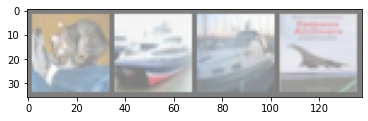

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(cifar_testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{cifar_classes[labels[j]]:5s}' for j in range(4)))

In [12]:
net = ResNet().to("cuda")
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in cifar_testloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        # zero the parameter gradients
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 74 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in cifar_classes}
total_pred = {classname: 0 for classname in cifar_classes}

# again no gradients needed
with torch.no_grad():
    for data in cifar_testloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[cifar_classes[label]] += 1
            total_pred[cifar_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 72.5 %
Accuracy for class: car   is 93.2 %
Accuracy for class: bird  is 76.1 %
Accuracy for class: cat   is 42.7 %
Accuracy for class: deer  is 71.8 %
Accuracy for class: dog   is 60.1 %
Accuracy for class: frog  is 84.9 %
Accuracy for class: horse is 77.2 %
Accuracy for class: ship  is 87.3 %
Accuracy for class: truck is 79.5 %
